# Imprementación de RedesNeuronales con los datos recogidos de Hopu en CTCON
## Multivaribale

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [16]:
df = pd.read_csv('calidadAireURDECON.csv',";",index_col=0,squeeze=True)
df = df[["pm25","pm10","co2","humedad","temperatura","presencia"]]# Quito la última columna
#df = df[["pm25","pm10","co2","humedad","temperatura"]]
df = df[["co2"]]# Solo dejo el CO2 porque vamos a jugar con una sola variable
df = df.drop_duplicates(subset=['co2'], keep="last")  # Elimino los duplicados 
#Los registros van de cada 5 minutos. 12 Registros = 1 hora. 48Registros = 4 horas 
df = df[:-48] #Me guardo las últimas 4 horas para la predicción
dfUltimas7Horas = df[-48:]
df.head()

,co2
fecha,
05-10-2021 10:39:17,134.77887
05-10-2021 10:44:17,139.66228
05-10-2021 10:49:17,159.06667
05-10-2021 10:54:17,121.99109
05-10-2021 10:59:18,116.49886


In [17]:
print(df.index.min())
print(df.index.max())

05-10-2021 10:39:17
13-10-2021 05:23:28


In [18]:
#df = df.set_index(pd.to_datetime(df.index, format='%Y%m%d', errors='ignore'))
df = df.set_index(pd.to_datetime(df.index, format='%d-%m-%Y %H:%M:%S'))
df.head()

,co2
fecha,
2021-10-05 10:39:17,134.77887
2021-10-05 10:44:17,139.66228
2021-10-05 10:49:17,159.06667
2021-10-05 10:54:17,121.99109
2021-10-05 10:59:18,116.49886


 ### Cargamos Datos Categóricos: Día y Mes

In [19]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df['horaDia'] = [x.hour for x in df.index]
df.head()

,co2,weekday,month,horaDia
fecha,,,,
2021-10-05 10:39:17,134.77887,1,10,10
2021-10-05 10:44:17,139.66228,1,10,10
2021-10-05 10:49:17,159.06667,1,10,10
2021-10-05 10:54:17,121.99109,1,10,10
2021-10-05 10:59:18,116.49886,1,10,10


In [20]:
df.describe()

,co2,weekday,month,horaDia
count,2233.000000,2233.000000,2233.0,2233.00000
mean,67.290816,2.828930,10.0,11.62069
std,36.716358,1.972782,0.0,6.98596
min,29.295370,0.000000,10.0,0.00000
25%,43.336980,1.000000,10.0,5.00000
50%,53.873173,3.000000,10.0,12.00000
75%,77.727710,5.000000,10.0,18.00000
max,272.036470,6.000000,10.0,23.00000


# Preprocesado de los datos

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [22]:
PASOS=7

# load dataset
values = df['co2'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('co2',axis=1)
#print(scaledMerge.values)
#scaledMerge.head()
# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head() #la variale Lag también se aplica a las columnas de mes y de día de la msena 

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2021-10-05 11:14:17,1.0,10.0,10.0,-0.130897,1.0,10.0,10.0,-0.090662,1.0,10.0,...,11.0,0.024935,1.0,10.0,11.0,-0.060098,1,10,11,0.117786
2021-10-05 11:19:17,1.0,10.0,10.0,-0.090662,1.0,10.0,10.0,0.069216,1.0,10.0,...,11.0,-0.060098,1.0,10.0,11.0,0.117786,1,10,11,-0.034289
2021-10-05 11:24:17,1.0,10.0,10.0,0.069216,1.0,10.0,10.0,-0.236259,1.0,10.0,...,11.0,0.117786,1.0,10.0,11.0,-0.034289,1,10,11,-0.152582
2021-10-05 11:29:17,1.0,10.0,10.0,-0.236259,1.0,10.0,10.0,-0.281510,1.0,10.0,...,11.0,-0.034289,1.0,10.0,11.0,-0.152582,1,10,11,-0.394639
2021-10-05 11:34:17,1.0,10.0,10.0,-0.281510,1.0,10.0,11.0,0.024935,1.0,10.0,...,11.0,-0.152582,1.0,10.0,11.0,-0.394639,1,10,11,-0.333377


### Dividimos en ser de entrenamiento y validación

In [23]:
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(2226, 29)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2021-10-05 11:14:17,1.0,10.0,10.0,-0.130897,1.0,10.0,10.0,-0.090662,1.0,10.0,...,-0.281510,1.0,10.0,11.0,0.024935,1.0,10.0,11.0,-0.060098,0.117786
2021-10-05 11:19:17,1.0,10.0,10.0,-0.090662,1.0,10.0,10.0,0.069216,1.0,10.0,...,0.024935,1.0,10.0,11.0,-0.060098,1.0,10.0,11.0,0.117786,-0.034289
2021-10-05 11:24:17,1.0,10.0,10.0,0.069216,1.0,10.0,10.0,-0.236259,1.0,10.0,...,-0.060098,1.0,10.0,11.0,0.117786,1.0,10.0,11.0,-0.034289,-0.152582
2021-10-05 11:29:17,1.0,10.0,10.0,-0.236259,1.0,10.0,10.0,-0.281510,1.0,10.0,...,0.117786,1.0,10.0,11.0,-0.034289,1.0,10.0,11.0,-0.152582,-0.394639
2021-10-05 11:34:17,1.0,10.0,10.0,-0.281510,1.0,10.0,11.0,0.024935,1.0,10.0,...,-0.034289,1.0,10.0,11.0,-0.152582,1.0,10.0,11.0,-0.394639,-0.333377


In [24]:
# split into train and test sets
values = newReframed.values
n_train_days = int( reframed.values.shape[0] * 0.70 )
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
#print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print("/*******************************************************************************/")
print("Datos de ENTRENAMIENTO, 567 reg en un array tridimensional de 567h*(1*7) -> ",x_train.shape)
print("Datos de VALIDACION del entrenamiento, 567 reg en una única dimension ->",y_train.shape)
print("Datos de PREDICCION, un mes de 30 días en un array tridimensional de 567h*(1*(7*3)) ->",  x_val.shape)#*3 columnas ahora que metemos más variables
print("Datos de VALIDACION de la predicción,  ->", y_val.shape)

/*******************************************************************************/
Datos de ENTRENAMIENTO, 567 reg en un array tridimensional de 567h*(1*7) ->  (1558, 1, 28)
Datos de VALIDACION del entrenamiento, 567 reg en una única dimension -> (1558,)
Datos de PREDICCION, un mes de 30 días en un array tridimensional de 567h*(1*(7*3)) -> (668, 1, 28)
Datos de VALIDACION de la predicción,  -> (668,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red Feedforward

### Como entradas son 21 columnas (7 pasos por 3 variables)

In [27]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*4),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [28]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 7)              203       
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
223/223 [==============================] - 0s 1ms/step - loss: 0.4463 - mse: 0.4718 - val_loss: 0.2113 - val_mse: 0.0558
Epoch 2/40
223/223 [==============================] - 0s 588us/step - loss: 0.1233 - mse: 0.0378 - val_loss: 0.3219 - val_mse: 0.1394
Epoch 3/40
223/223 [==============================] - 0s 635us/step - loss: 0.0991 - mse: 0.0258 - val_loss: 0.3468 - va

# Visualizamos resultados

668


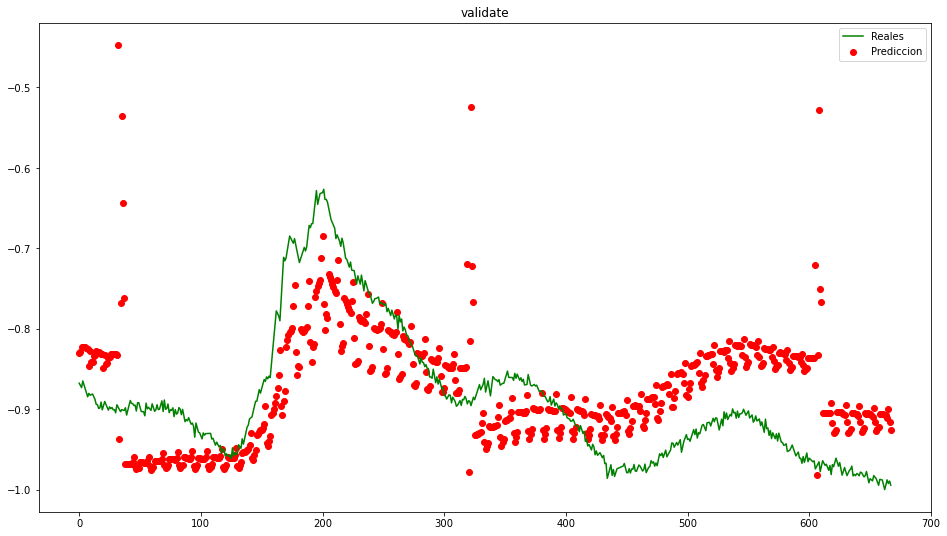

In [29]:
results=model.predict(x_val)
print( len(results) )
plt.plot(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.legend( ["Reales","Prediccion"])
plt.title('validate')
plt.show()

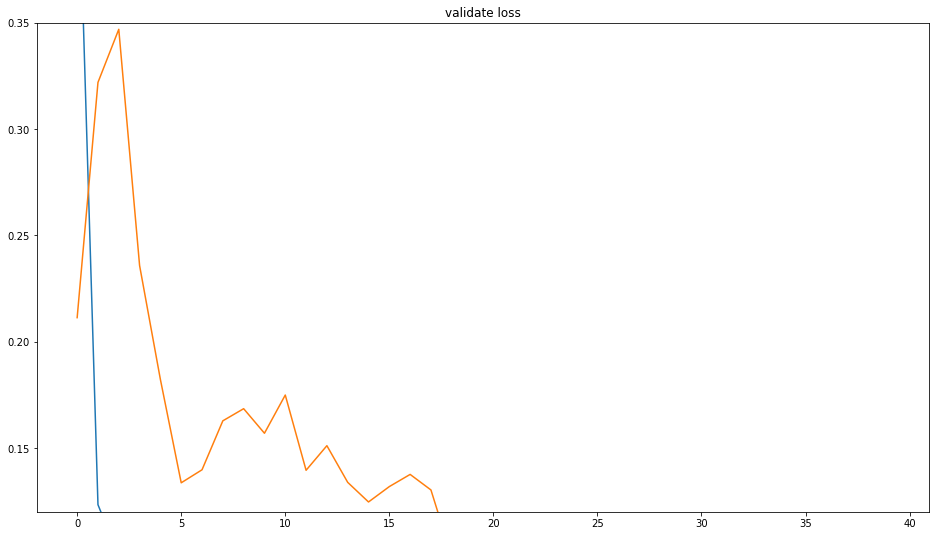

In [30]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [31]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,45.349999,49.847582,-4.497583
1,45.130816,50.007922,-4.877106
2,44.689671,50.854770,-6.165099
3,45.689755,50.763503,-5.073747
4,45.031359,50.801360,-5.770000
5,43.974464,50.776973,-6.802509
6,44.163315,50.646568,-6.483254
7,43.296116,50.580165,-7.284049
8,43.811622,47.931092,-4.119470
9,43.529638,50.229456,-6.699818


<AxesSubplot:>

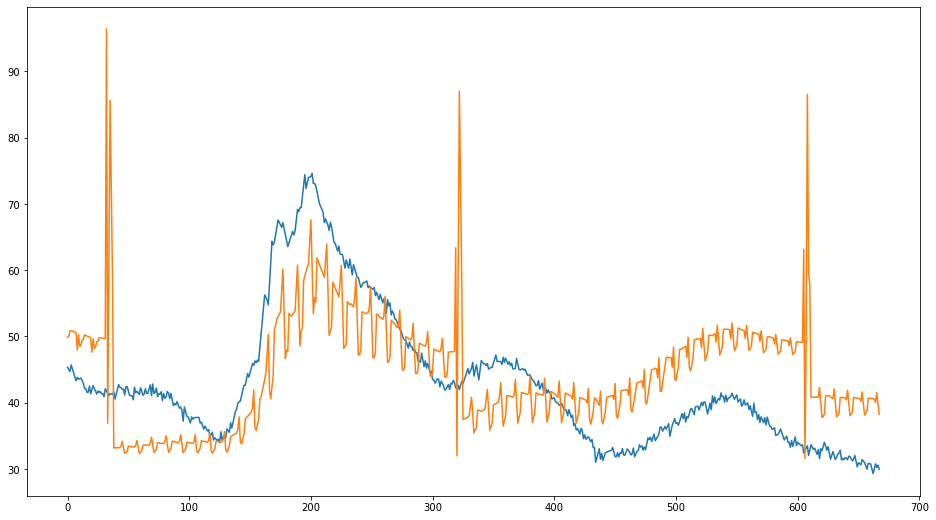

In [32]:
compara2['real'].plot()
compara2['prediccion'].plot()

## Predicción de datos 


In [33]:
dfUltimas7Horas = df[-48:]
dfUltimas7Horas.head()
dfUltimas7Horas = dfUltimas7Horas.set_index(pd.to_datetime(dfUltimas7Horas.index, format='%d-%m-%Y %H:%M:%S'))
dfUltimas7Horas['weekday']=[x.weekday() for x in dfUltimas7Horas.index]
dfUltimas7Horas['month']=[x.month for x in dfUltimas7Horas.index]
dfUltimas7Horas.describe()

,co2,weekday,month,horaDia,scaled
count,48.000000,48.0,48.0,48.000000,48.000000
mean,31.444059,2.0,10.0,2.895833,-0.982296
std,1.054535,0.0,0.0,1.258834,0.008689
min,29.295370,2.0,10.0,1.000000,-1.000000
25%,30.706279,2.0,10.0,2.000000,-0.988375
50%,31.400934,2.0,10.0,3.000000,-0.982652
75%,32.054591,2.0,10.0,4.000000,-0.977266
max,34.034040,2.0,10.0,5.000000,-0.960957


In [34]:
#dfUltimas7Horas = df[-48:]
scaledMerge=dfUltimas7Horas.drop('co2',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2021-10-13 01:57:51,2.0,10.0,1.0,-0.971616,2.0,10.0,1.0,-0.963346,2.0,10.0,...,-0.970982,2.0,10.0,1.0,-0.966377,2.0,10.0,1.0,-0.979044,-0.982111
2021-10-13 02:02:25,2.0,10.0,1.0,-0.963346,2.0,10.0,1.0,-0.960957,2.0,10.0,...,-0.966377,2.0,10.0,1.0,-0.979044,2.0,10.0,1.0,-0.982111,-0.975816
2021-10-13 02:07:39,2.0,10.0,1.0,-0.960957,2.0,10.0,1.0,-0.969381,2.0,10.0,...,-0.979044,2.0,10.0,1.0,-0.982111,2.0,10.0,2.0,-0.975816,-0.972620
2021-10-13 02:12:53,2.0,10.0,1.0,-0.969381,2.0,10.0,1.0,-0.970982,2.0,10.0,...,-0.982111,2.0,10.0,2.0,-0.975816,2.0,10.0,2.0,-0.972620,-0.976359
2021-10-13 02:17:28,2.0,10.0,1.0,-0.970982,2.0,10.0,1.0,-0.966377,2.0,10.0,...,-0.975816,2.0,10.0,2.0,-0.972620,2.0,10.0,2.0,-0.976359,-0.982626


In [35]:
values = newReframed.values
x_test = values[:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
#print(x_test.shape)
#print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()
ultDiaSemana

2

In [36]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [37]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

ValueError: in user code:

    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\jgonzalez\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 28 but received input with shape [None, 1, 29]


In [38]:
adimen = [x for x in results]    
#print(adimen)
inverted = scaler.inverse_transform(adimen)
#inverted

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()


In [ ]:
print(prediccion1SemanaDiciembre.shape)
print( len(prediccion1SemanaDiciembre) )
plt.plot(range(len(prediccion1SemanaDiciembre)),prediccion1SemanaDiciembre,c='g')
plt.scatter(range(len(dfUltimas7Horas.co2)),dfUltimas7Horas.co2,c='r')
plt.title('validate')

plt.legend( ["Prediccion","Reales"])
plt.show()